In [1]:
from package.gnn.graph_attention_network import (GNN, FlattenedLayerNorm, expand_graph,
                                                 NodeTransformer, TransformDimensionEncoder)
from package.writhe.writhe import Writhe, to_writhe_matrix
from package.utils.utils import group_by
from package.gnn.writhe_graph import WritheGraph
from package.mdtool.mdtool import ResidueDistances
from package.writhe.writhe import Writhe
from package.utils.utils import lsdir, filter_strs, load_array_dir
from package.gnn.lightning_graph import GraphDataSet, TimeSeriesData, load_raw_data, GraphDataModule, DataSet
from package.msmtool.msmtool import standardize, mean, std, tCCA
import matplotlib.pyplot as plt
from importlib import reload
import torch_geometric
import torch
import mdtraj as md
import os
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def rm_inf(x):
    x[x==np.inf] = 0
    return x

 # Load a trajectory and build a feature graph

In [14]:
sele = "protein and (resid 0 to 70)"
pdb = "/home/t/writhe/actr/actr.pdb"
obs_dir = "/home/t/writhe/actr/data/observables"
traj = md.load("/home/t/writhe/actr/ACTR-a99SBdisp-Traj.dcd", 
               top="/home/t/writhe/actr/actr.pdb", stride=1000)
traj = traj.atom_slice(traj.top.select(sele))
files = lsdir(obs_dir)
writhe_files = lsdir("/home/t/writhe/actr/data/writhe", exclude="npy")


graph = WritheGraph(traj)
# compute and add features using the class
graph.add_dihedrals()
graph.add_angles()
graph.add_hbonds()
graph.add_intra_distances()
graph.add_dssp()
graph.make_edge_dict()
graph_0 = graph.get_graph(0)
node_features, edge_features, edge_indices = expand_graph(graph_0)
print(f" The class will build a heterograph with the fewest unique edges possible : \n", edge_features.keys())

7.051136493682861
 The class will build a heterograph with the fewest unique edges possible : 
 dict_keys([('res', '45', 'res'), ('res', '345', 'res'), ('res', '245', 'res'), ('res', '0145', 'res')])


 # Here are the ensemble averaged adjecency matrices that represent individual features

 ## note that this is a small example and not the full set of features used in training

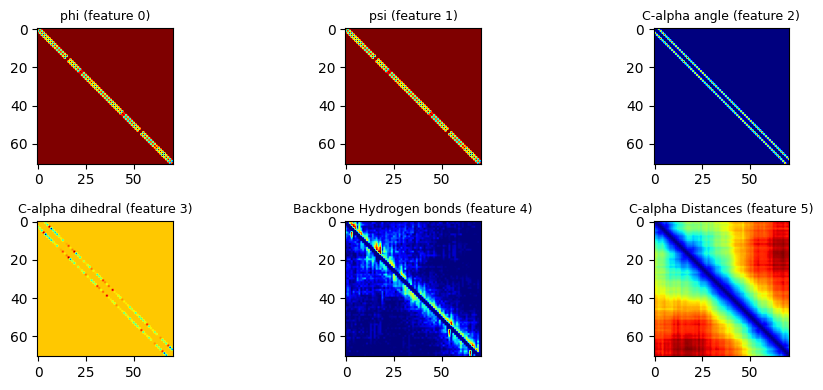

In [23]:
titles = ["phi", "psi", "C-alpha angle", "C-alpha dihedral", "Backbone Hydrogen bonds", "C-alpha Distances"]
fig, axes = plt.subplots(2, 3, figsize=(10, 4))
for j, (i, title, ax) in enumerate(zip(graph.adj.mean(0), titles, axes.flat)):
    ax.imshow(i, cmap="jet")
    ax.set_title(f"{title} (feature {j})", fontsize=9)
plt.tight_layout()

 # Can easily add precomputed features and features the class does not compute

In [ ]:
graph = WritheGraph(traj)

# compute and add features using the class
graph.add_dihedrals()
graph.add_angles()
#graph.add_rsa()
# load precomputed features and add them to the graph by setting the properties adj and node_features
for string in ["rsa", "bb_coord", "norm_vol", "dssp"]:
    key = filter_strs(files, keyword=string, exclude="total")[0]
    print(key)
    feature = np.load(key)
    print(feature.shape)
    feature = standardize(feature.astype(float))
    graph.node_features = feature


feature = standardize(np.load(filter_strs(files, keyword="hbond")[0]))
graph.adj = feature

for i in [1, 3]:
    feature = standardize(Writhe.load(filter_strs(writhe_files, keyword=str(i))[0]).adj_matrix())
    graph.adj = feature
    

graph.adj = standardize(ResidueDistances.load("/home/t/writhe/actr/data/distance_dict").matrix())

graph.make_edge_dict()

# extra the graphs into a list and use the GraphDataSet class to save and collate
graphs = GraphDataSet(file="/home/t/writhe/actr/graphs.pt",
                      data_list = list(map(graph.get_graph, range(graph.nf)))
                     )


 # We have a neural net class that will make a corresponding graph neural network automatically

In [11]:
# set file 
file = "/home/t/writhe/actr/graphs.pt"
# load data
data = GraphDataModule(data_path=file, batch_size=10, lagtime=1, stride=1000)
# get batch
batch = next(iter(data.train_dataloader()))
# put on GPU
b0, bt = (b.to("cuda:0", non_blocking=True) for b in batch)
# instantiate net
net = GNN(graph=data.train_dataset[0][0].to(device, non_blocking=True),
          output_dim=10,
          num_graph_layers=2,
          num_final_node_layers=3)
# put on device
net.to(device)
# attempt to pass data through network with both on GPU
net(b0.to(device))

tensor([[0.0534, 0.0537, 0.0626, 0.0699, 0.0934, 0.0530, 0.2685, 0.2391, 0.0535,
         0.0530],
        [0.0508, 0.0531, 0.0503, 0.0508, 0.0899, 0.1119, 0.3748, 0.1173, 0.0504,
         0.0507],
        [0.0881, 0.0541, 0.0497, 0.0495, 0.1066, 0.0495, 0.0867, 0.4174, 0.0494,
         0.0490],
        [0.0825, 0.0544, 0.0544, 0.0549, 0.0551, 0.0551, 0.1704, 0.1100, 0.0794,
         0.2837],
        [0.0584, 0.1515, 0.0580, 0.2371, 0.1337, 0.0572, 0.0915, 0.0966, 0.0577,
         0.0582],
        [0.0507, 0.0511, 0.0584, 0.4035, 0.0506, 0.0729, 0.0886, 0.1140, 0.0595,
         0.0507],
        [0.0552, 0.0884, 0.0552, 0.0853, 0.0846, 0.0544, 0.3455, 0.1214, 0.0547,
         0.0554],
        [0.0507, 0.0501, 0.0623, 0.0503, 0.0505, 0.1170, 0.1991, 0.3196, 0.0504,
         0.0501],
        [0.0550, 0.1083, 0.0613, 0.3197, 0.0558, 0.0870, 0.1234, 0.0553, 0.0550,
         0.0792],
        [0.0509, 0.0600, 0.0874, 0.0516, 0.1535, 0.0514, 0.3860, 0.0515, 0.0510,
         0.0568]], device='c

 # architecture is based on node update with attention, node update with any neural net we want (both contained in conv_neuron) and edge updates with any neural network we want (EdgeMLP)
 # Nodes are then reduced to the desired output using transformer encoders on the node embeddings. First we reduce the embeddings to 1 then we reduce the number of nodes to the target dimension

In [12]:
print(net)

GNN(
  (graph_layers): ModuleList(
    (0-1): 2 x GraphBlock(
      (edge_mlp): HeteroEdgeMLP(
        (layers): ModuleDict(
          (res_4567_res): ResidualBlock(
            (layers): Sequential(
              (0): Linear(in_features=4, out_features=4, bias=True)
              (1): LeakyReLU(negative_slope=0.01)
              (2): Linear(in_features=4, out_features=4, bias=True)
            )
            (norm): FlattenedLayerNorm(
              (norm): Sequential(
                (0): Unflatten(dim=0, unflattened_size=(-1, 4556))
                (1): LayerNorm((4556, 4), eps=1e-05, elementwise_affine=True)
                (2): Flatten(start_dim=0, end_dim=1)
              )
            )
          )
          (res_34567_res): ResidualBlock(
            (layers): Sequential(
              (0): Linear(in_features=5, out_features=5, bias=True)
              (1): LeakyReLU(negative_slope=0.01)
              (2): Linear(in_features=5, out_features=5, bias=True)
            )
          

 # results from using this workflow to train a VAMPnet

In [31]:
subplots_proj2d(items["x.best"]

<function package.visualize.visualize.subplots_proj2d(x: numpy.ndarray, c: numpy.ndarray, rows: int, cols: int, indices_list: list, dscrs: list, y: numpy.ndarray = None, ylabel=None, xlabel=None, title: str = None, title_pad=1.05, cbar_label: 'str or list' = None, font_scale: float = 0.6, share_extent: bool = True, sharey: bool = False, sharex: bool = False, vmin: float = None, vmax: float = None, bins: int = 100, figsize: tuple = (6, 5))>

Text(0.5, 0.98, 'State Probabilities')

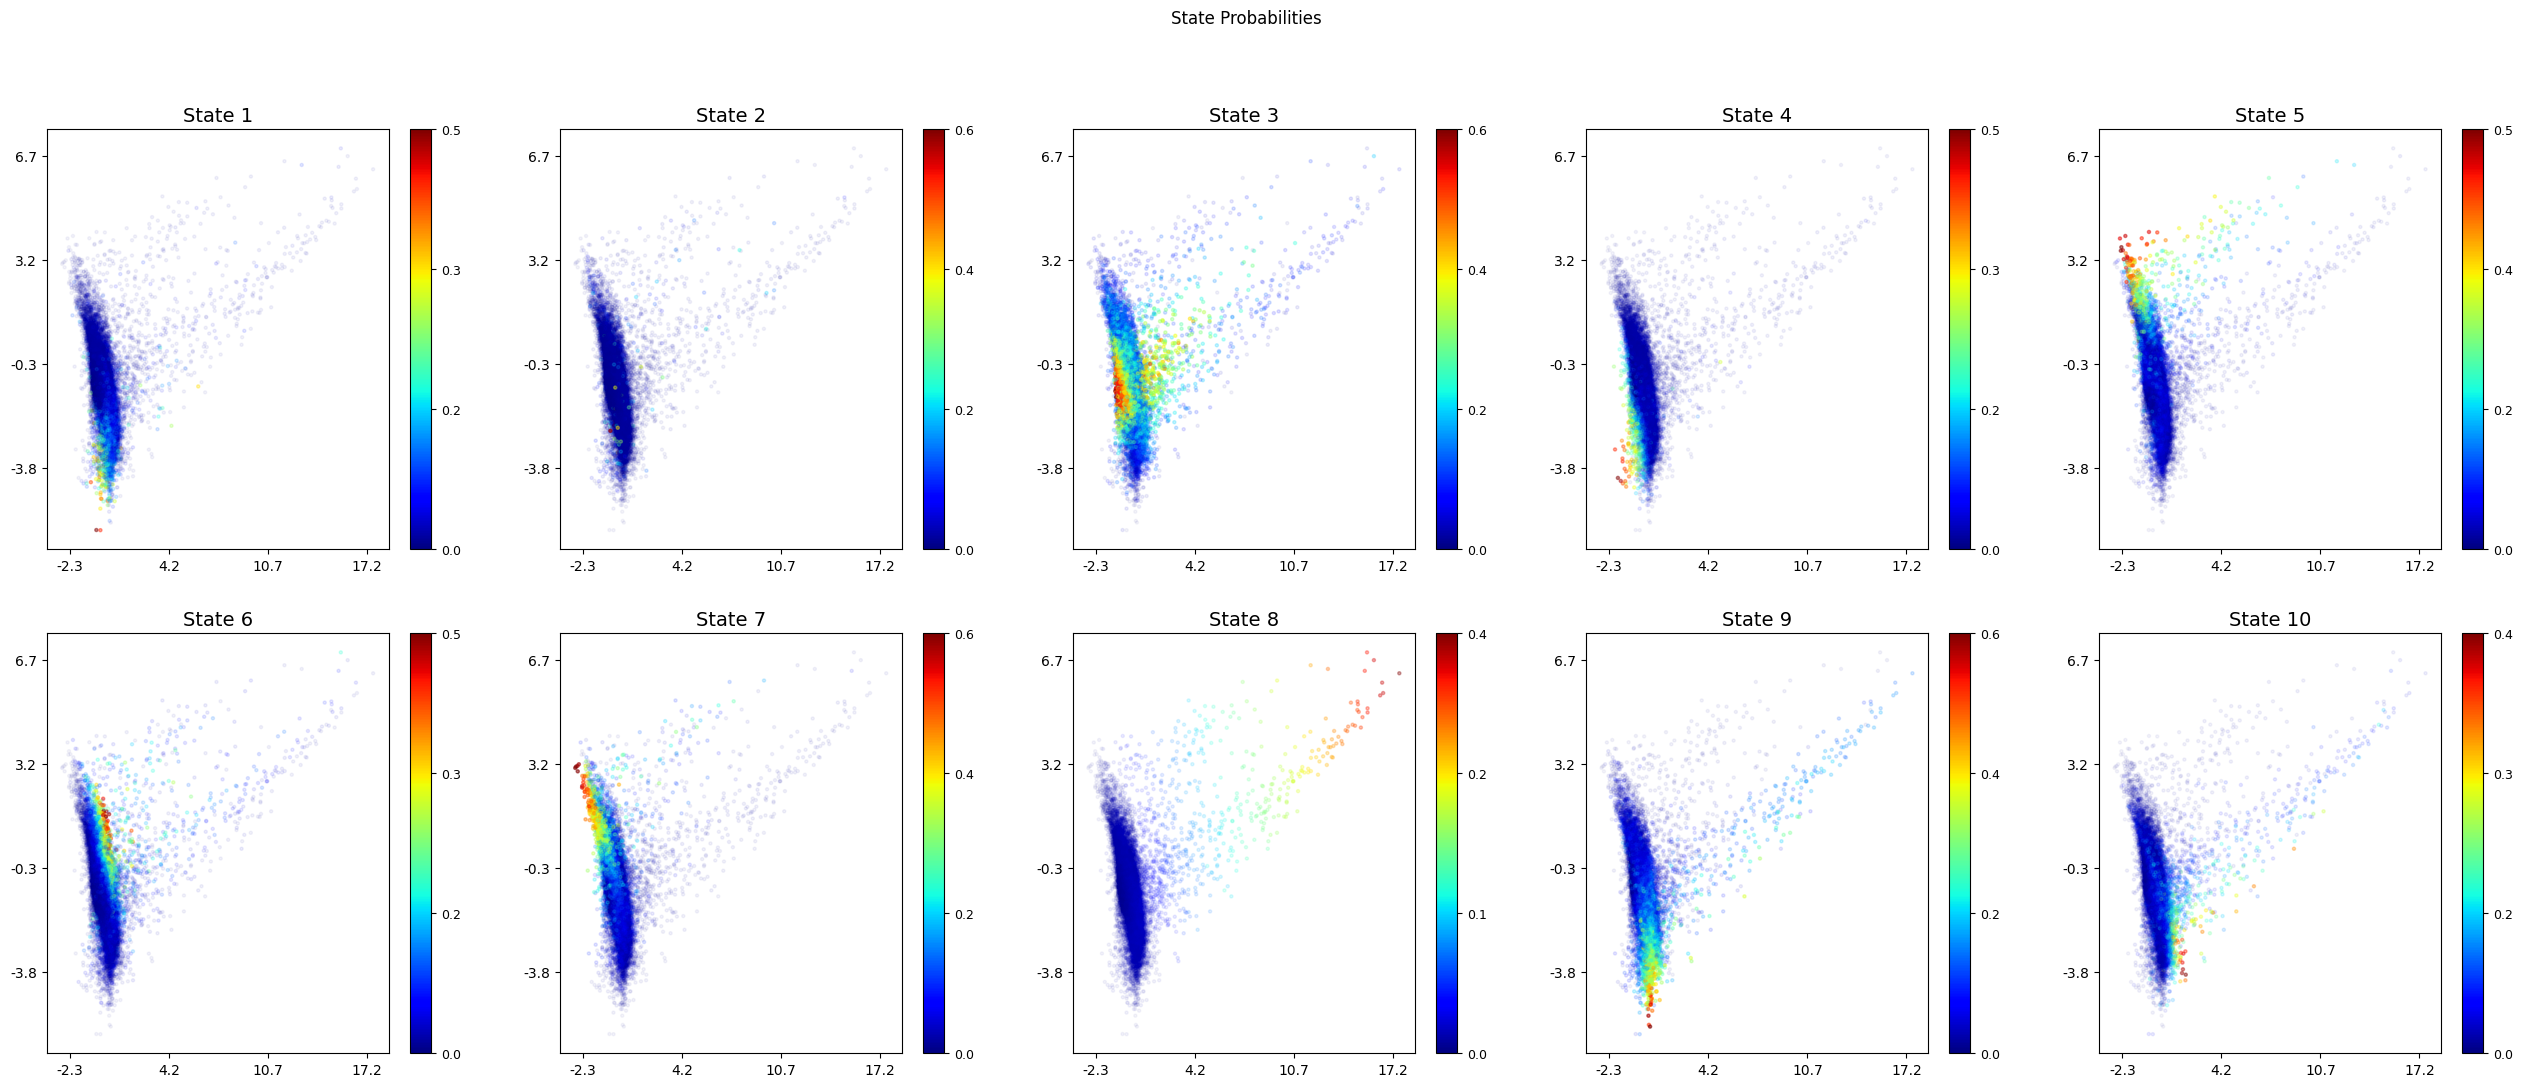

In [38]:
fig, axes = plt.subplots(2,5, figsize=(32, 12))
from package.visualize.visualize import proj2d

for i, (distribution, ax) in enumerate(zip(items["x.best"].T, axes.flat)):
    proj2d(items["tcca.best"][:,:2],
           c=distribution,
           ax=ax,
           alpha = distribution,
           dot_size=5,
           title = f"State {i+1}")
fig.suptitle("State Probabilities")

dict_keys(['x.best', 'dtraj.last', 'tcca.best', 'x.last', 'tcca.last', 'dtraj.best'])


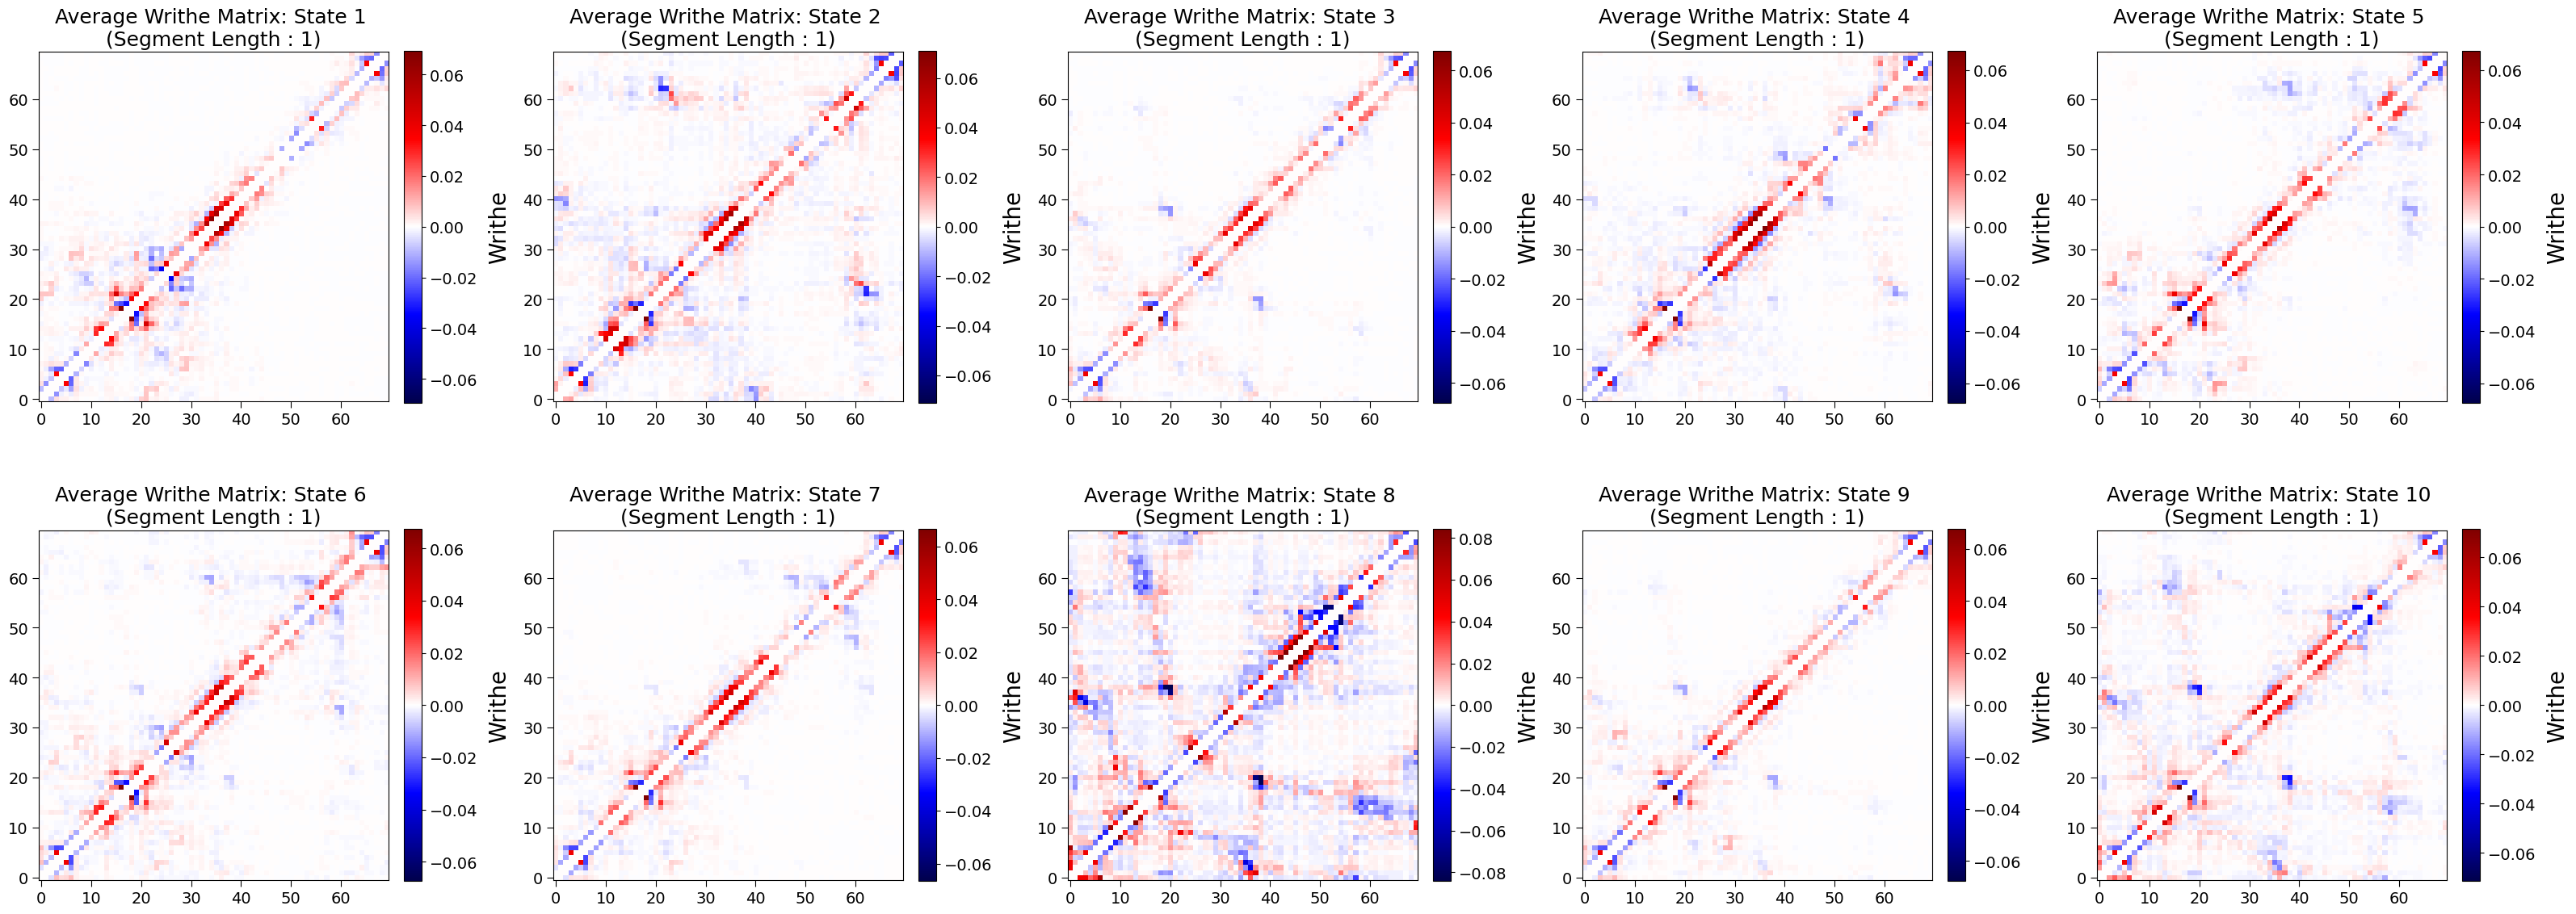

In [26]:
items = load_array_dir("/home/t/writhe/actr/graph/max_epochs:10000.lagtime:8.epsilon:1e-08.batch_size:1000.accum_grad_batches:1.stride:1.learning_rate:1e-07.output_dim:10/results_0")
print(items.keys())

writhe_files = lsdir("/home/t/writhe/actr/data/writhe", "dict")
writhe = Writhe.load(writhe_files[0])
exp_w = (items["x.best"] / items["x.best"].sum(0)).T @ writhe.writhe_features
exp_w = [to_writhe_matrix(i.reshape(1, -1), 71, 1) for i in exp_w]

frames = group_by(items["dtraj.best"])
fig, axes = plt.subplots(2,5, figsize=(32, 12))
for i, (frame, ax) in enumerate(zip(frames, axes.flat)):
    writhe.plot_writhe_matrix(index=frame, ax=ax, dscr=f"State {i+1}", font_scale=2)
plt.tight_layout()

In [ ]:
# make instance of writhe graph

# add edge features
# graph.add_dihedrals() #0,1
# graph.add_angles() #2,3
# graph.add_intra_distances() #4
# graph.add_writhe(segment_length = 1) #5
# graph.add_writhe(segment_length = 3) #6
# graph.make_edge_dict()
# graphs = GraphDataSet(list(map(graph.get_graph, range(graph.nf))))

# graph.add_writhe(segment_length = 5) #7
# add node_features
# graph.add_ligand_distances() #0
# graph.add_dssp() #1
# graph.add_rsa() #2
# set up

2024-03-13 00:55:43,426	INFO worker.py:1636 -- Started a local Ray instance.
